In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import scipy.stats as stats
import tqdm
import matplotlib.cm as col
colormap_normal = col.get_cmap("viridis")
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d


/tmp/zu992399/login23-3_82949/ipykernel_246564/3087564691.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap_normal = col.get_cmap("viridis")


In [3]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = False
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

In [16]:
generate_data = False
directory = "/hpcwork/zu992399/look_elsewhere/binned_test/"

bins = 5
bins_edge = 2
N = 25000
N_tests = 100000

sigma3 = 1-0.9973
sigma5 = 5.7*1e-7

# Generate Data

In [6]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv


def p_to_significance(p):
    return norm.isf(p)

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_binomial(N_data, N_BT, N_total):
    p_value = 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)
    p_left = stats.binom.cdf(N_data, N_total, N_BT/N_total) 
    return np.min(np.array([p_value, p_left]), axis=0)*2

In [15]:
if generate_data:
    def sample_hist(N, exp):
        return np.random.binomial(N, exp/N)

    def do_test_val(N_tests, bins, N, bins_edge = None, val=True, uniform=False):
        rv = multivariate_normal([0,0], [[1,0],[0,1]])
        if bins_edge is None:
            edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
        else:
            edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]
        
        if uniform: 
            exp = np.ones((bins,bins))*N/(bins**2)
        else:
            exp = np.zeros((bins,bins))
            for i in range(bins):
                for j in range(bins):
                    exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

        p_train = np.zeros((bins,bins, N_tests))
        p_val = np.zeros((bins,bins, N_tests))
        p_train_val = np.zeros((bins,bins, N_tests))
        p_test = np.zeros((bins,bins, N_tests))
        for k in tqdm.tqdm(range(N_tests)):
            hist_train = sample_hist(N, exp)
            p_train[:,:,k] = p_value_binomial(hist_train, exp, N)
            if val: 
                hist_val = sample_hist(N, exp)
                p_val[:,:,k] = p_value_binomial(hist_val, exp, N)
                p_train_val[:,:,k] = p_value_binomial(hist_train+hist_val, exp*2, 2*N)
            hist_test = sample_hist(N, exp)
            p_test[:,:,k] = p_value_binomial(hist_test, exp, N)

        if val:
            return p_train, p_val, p_train_val, p_test 
        else:
            return p_train, p_test

In [6]:
if generate_data:
    p_train_arr = np.zeros((10, N_tests))
    p_test_arr = np.zeros((10, N_tests))
    
    p_train, p_test = do_test_val(10*N_tests, bins, N, bins_edge=bins_edge, val=False)
    p_train_split = np.array_split(p_train, 10, axis=-1)
    p_test_split = np.array_split(p_test, 10, axis=-1) 
    for i in range(10):
        min_ind_on_train = np.argmin(p_train_split[i].reshape((bins*bins, N_tests)), axis=0)

        p_train_arr[i] = np.array([p_train_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
        p_test_arr[i] = np.array([p_test_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
    np.save(directory+"validation/p_train_10_tests.npy", p_train_arr)
    np.save(directory+"validation/p_test_10_tests.npy", p_test_arr)

In [16]:
if generate_data:
    p_train_arr = np.zeros((10, N_tests))
    p_test_arr = np.zeros((10, N_tests))
    
    p_train, p_test = do_test_val(10*N_tests, bins, N, bins_edge=bins_edge, val=False, uniform=True)
    p_train_split = np.array_split(p_train, 10, axis=-1)
    p_test_split = np.array_split(p_test, 10, axis=-1) 
    for i in range(10):
        min_ind_on_train = np.argmin(p_train_split[i].reshape((bins*bins, N_tests)), axis=0)

        p_train_arr[i] = np.array([p_train_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
        p_test_arr[i] = np.array([p_test_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
    np.save(directory+"validation/p_train_10_tests_uniform_big.npy", p_train_arr)
    np.save(directory+"validation/p_test_10_tests_uniform_big.npy", p_test_arr)

100%|██████████| 1000000/1000000 [05:17<00:00, 3147.54it/s]


In [8]:
if generate_data:
    p_train_arr = np.zeros((10, N_tests))
    p_test_arr = np.zeros((10, N_tests))
    
    p_train, p_test = do_test_val(10*N_tests, bins, N/2, bins_edge=bins_edge, val=False)
    p_train_split = np.array_split(p_train, 10, axis=-1)
    p_test_split = np.array_split(p_test, 10, axis=-1) 
    for i in range(10):
        min_ind_on_train = np.argmin(p_train_split[i].reshape((bins*bins, N_tests)), axis=0)

        p_train_arr[i] = np.array([p_train_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
        p_test_arr[i] = np.array([p_test_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])

    np.save(directory+"validation/p_train_10_tests_half.npy", p_train_arr)
    np.save(directory+"validation/p_test_10_tests_half.npy", p_test_arr)

In [17]:
if generate_data:
    p_train_arr = np.zeros((10, N_tests))
    p_test_arr = np.zeros((10, N_tests))
    
    p_train, p_test = do_test_val(10*N_tests, bins, N/2, bins_edge=bins_edge, val=False, uniform=True)
    p_train_split = np.array_split(p_train, 10, axis=-1)
    p_test_split = np.array_split(p_test, 10, axis=-1) 
    for i in range(10):
        min_ind_on_train = np.argmin(p_train_split[i].reshape((bins*bins, N_tests)), axis=0)

        p_train_arr[i] = np.array([p_train_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
        p_test_arr[i] = np.array([p_test_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])

    np.save(directory+"validation/p_train_10_tests_half_uniform_big.npy", p_train_arr)
    np.save(directory+"validation/p_test_10_tests_half_uniform_big.npy", p_test_arr)

100%|██████████| 1000000/1000000 [05:14<00:00, 3183.21it/s]


In [18]:
def do_test_kfold_valset(N_tests, bins, N, bins_edge = None, folds=5, val=True, uniform=True):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    if uniform: 
        exp = np.ones((bins,bins))*N/(bins**2)
    else:
        exp = np.zeros((bins,bins))
        for i in range(bins):
            for j in range(bins):
                exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    p_add = np.zeros((N_tests))
    p_add_with_val = np.zeros((N_tests))
    p_only_train = np.zeros((N_tests, bins*bins, folds))
    p_train = np.zeros((N_tests, bins*bins, folds))
    p_val = np.zeros((N_tests, bins*bins, folds))
    train_val_split = int((folds-1)/2)
    for k in tqdm.tqdm(range(N_tests)):
        hist = np.zeros((bins,bins, folds))
        N_test = np.zeros((folds))
        exp_test = np.zeros((folds))
        best_bin = np.zeros((folds), dtype=int)

        N_test_with_val = np.zeros((folds))
        exp_test_with_val = np.zeros((folds))
        best_bin_with_val = np.zeros((folds), dtype=int)

        for m in range(folds):
            hist[:,:,m] = sample_hist(N//folds, exp//folds)

        for m in range(folds):
            inds = np.roll(np.array(range(folds)), m)

            if val:
                p_train[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[:train_val_split]],axis=-1), exp*(train_val_split)/folds, N*(train_val_split)/folds).flatten()
                p_val[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[train_val_split:-1]],axis=-1), exp*((folds-train_val_split-1))/folds, N*(folds-train_val_split-1)/folds).flatten()
            p_only_train[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[:-1]],axis=-1), exp*(folds-1)/folds, N*(folds-1)/folds).flatten()

            best_bin[m] = np.argmin(p_only_train[k, :,m])
            N_test[m] = hist[:,:,inds[-1]].flatten()[best_bin[m]]
            exp_test[m] = exp.flatten()[best_bin[m]]/5

            if val:
                best_bin_with_val[m] = np.argmin(np.argsort(np.argsort(p_train[k, :,m]))+np.argsort(np.argsort(p_val[k,:, m])))
                N_test_with_val[m] = hist[:,:,inds[-1]].flatten()[best_bin_with_val[m]]
                exp_test_with_val[m] = exp.flatten()[best_bin_with_val[m]]/5
            
        p_add[k] = p_value_binomial(np.sum(N_test), np.sum(exp_test), N)

        if val:
            p_add_with_val[k] = p_value_binomial(np.sum(N_test_with_val), np.sum(exp_test_with_val), N)

    if val:
        return p_add, p_add_with_val
    else:
        return p_add


In [11]:
if generate_data:
    p_add = do_test_kfold_valset(N_tests*5, bins, N, bins_edge=bins_edge, val=False)
#np.save(directory+"k_fold/addition_method_test.npy", p_add.reshape(10, N_tests))

In [12]:
if generate_data:
    p_add2 = do_test_kfold_valset(N_tests*5, bins, N, bins_edge=bins_edge, val=False)
#np.save(directory+"k_fold/addition_method_test.npy", p_add.reshape(10, N_tests))

In [13]:
if generate_data:
    np.save(directory+"k_fold/addition_method_test.npy", np.concatenate((p_add, p_add2)).reshape(10, N_tests))

In [19]:
if generate_data:
    p_add = do_test_kfold_valset(N_tests*10, bins, N, bins_edge=bins_edge, val=False, uniform=True)
    np.save(directory+"k_fold/addition_method_test_uniform_big.npy", p_add.reshape(10, N_tests))

100%|██████████| 1000000/1000000 [18:04<00:00, 921.66it/s]


# Get trials factor

In [ ]:
"""
p_train = np.load(directory+"validation/p_train_10_tests.npy")
p_test_half = np.load(directory+"validation/p_test_10_tests_half.npy")
p_kfold = np.load(directory+"k_fold/addition_method_test.npy")

p_train_uniform = np.load(directory+"validation/p_train_10_tests_uniform.npy")
p_test_half_uniform = np.load(directory+"validation/p_test_10_tests_half_uniform.npy")
p_kfold_uniform = np.load(directory+"k_fold/addition_method_test_uniform.npy")

"""
p_train = np.load(directory+"validation/p_train_10_tests_uniform_big.npy")
p_test_half = np.load(directory+"validation/p_test_10_tests_half_uniform_big.npy")
p_kfold = np.load(directory+"k_fold/addition_method_test_uniform_big.npy")


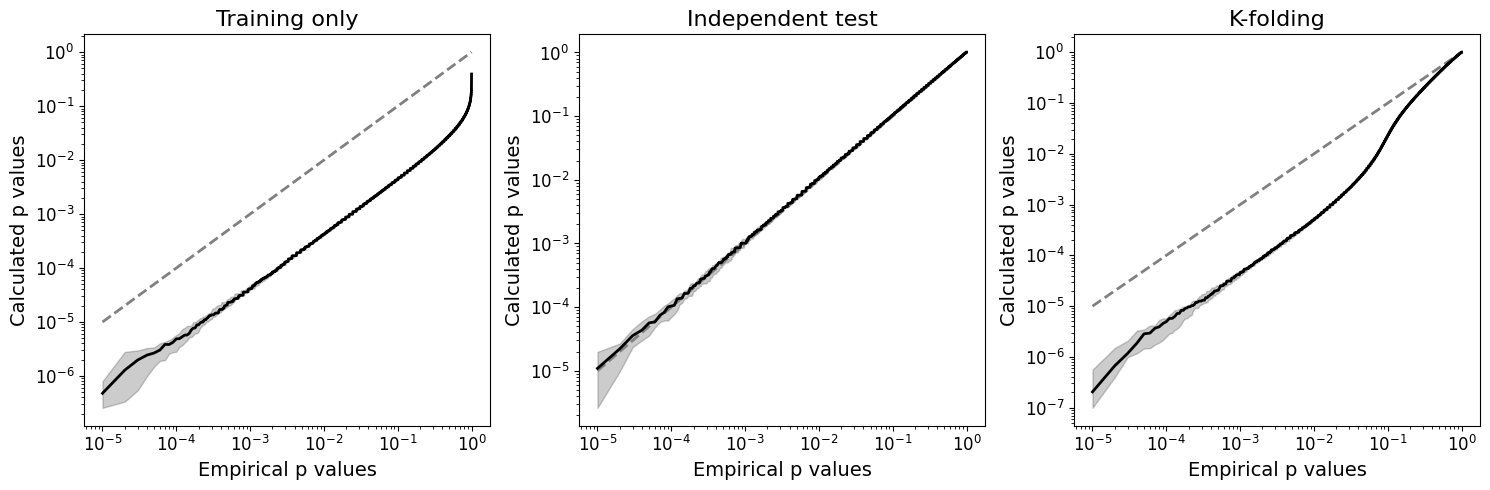

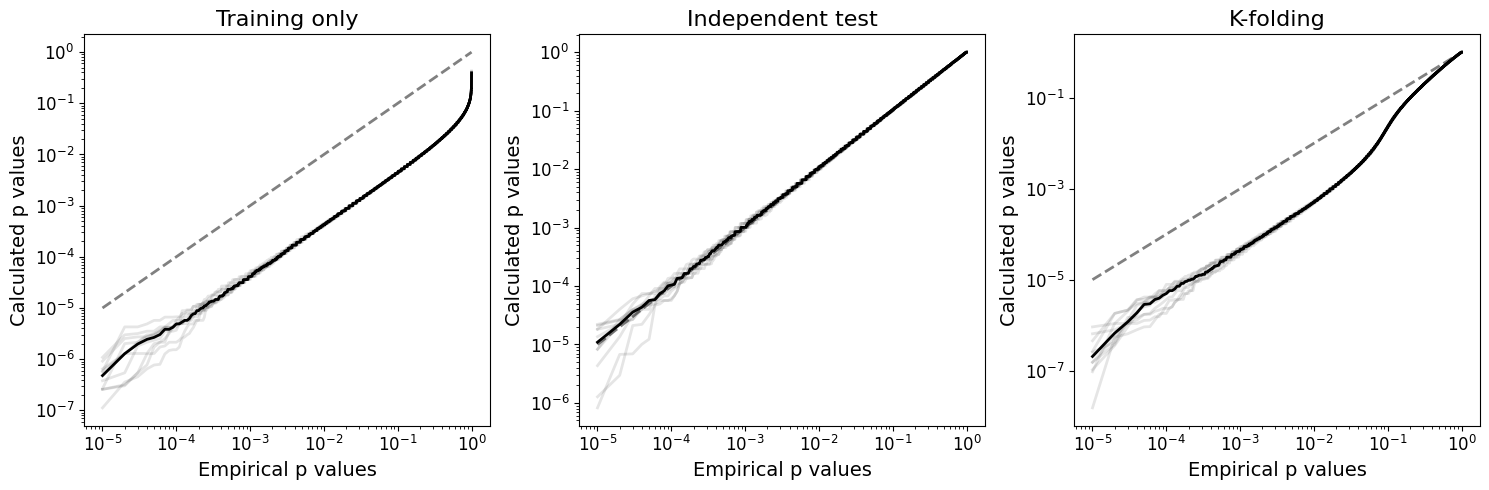

In [8]:
def plot_pvalues(ax, pvalues, counts, title, color="black", mean=False, errorband=True):
    pvalues = np.sort([np.sort(pvalues[i]) for i in range(10)])
    ax[0].plot(counts, np.median(pvalues, axis=0), color=color)
    if errorband:
        ax[0].fill_between(counts, np.percentile(pvalues,16, axis=0),np.percentile(pvalues,84, axis=0), color=color, alpha=0.2)
    else:
        for j in range(10):
            ax[0].plot(counts, pvalues[j], color="black", alpha=0.1)
    ax[0].set_title(title)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax = ax.reshape((1,3))
counts = np.arange(1,N_tests+1)/N_tests
for i in range(3):
    ax[0,i].set_xlabel("Empirical p values")
    ax[0,i].set_ylabel("Calculated p values")
    ax[0,i].set_xscale("log")
    ax[0,i].set_yscale("log")
    ax[0,i].plot(counts, counts, color="grey", linestyle="dashed")
counts = np.arange(1,N_tests+1)/N_tests
plot_pvalues(ax[:,0], p_train, counts, "Training only")
plot_pvalues(ax[:,1], p_test_half, counts, "Independent test")
plot_pvalues(ax[:,2], p_kfold, counts, "K-folding")    
#ax[0,1].legend()
fig.tight_layout()
fig.savefig("plots/binned_errorbands.pdf")

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax = ax.reshape((1,3))
counts = np.arange(1,N_tests+1)/N_tests
for i in range(3):
    ax[0,i].set_xlabel("Empirical p values")
    ax[0,i].set_ylabel("Calculated p values")
    ax[0,i].set_xscale("log")
    ax[0,i].set_yscale("log")
    ax[0,i].plot(counts, counts, color="grey", linestyle="dashed")
counts = np.arange(1,N_tests+1)/N_tests
plot_pvalues(ax[:,0], p_train, counts, "Training only", errorband=False)
plot_pvalues(ax[:,1], p_test_half, counts, "Independent test", errorband=False)
plot_pvalues(ax[:,2], p_kfold, counts, "K-folding", errorband=False)    
#ax[0,1].legend()
fig.tight_layout()
fig.savefig("plots/binned_runs.pdf")

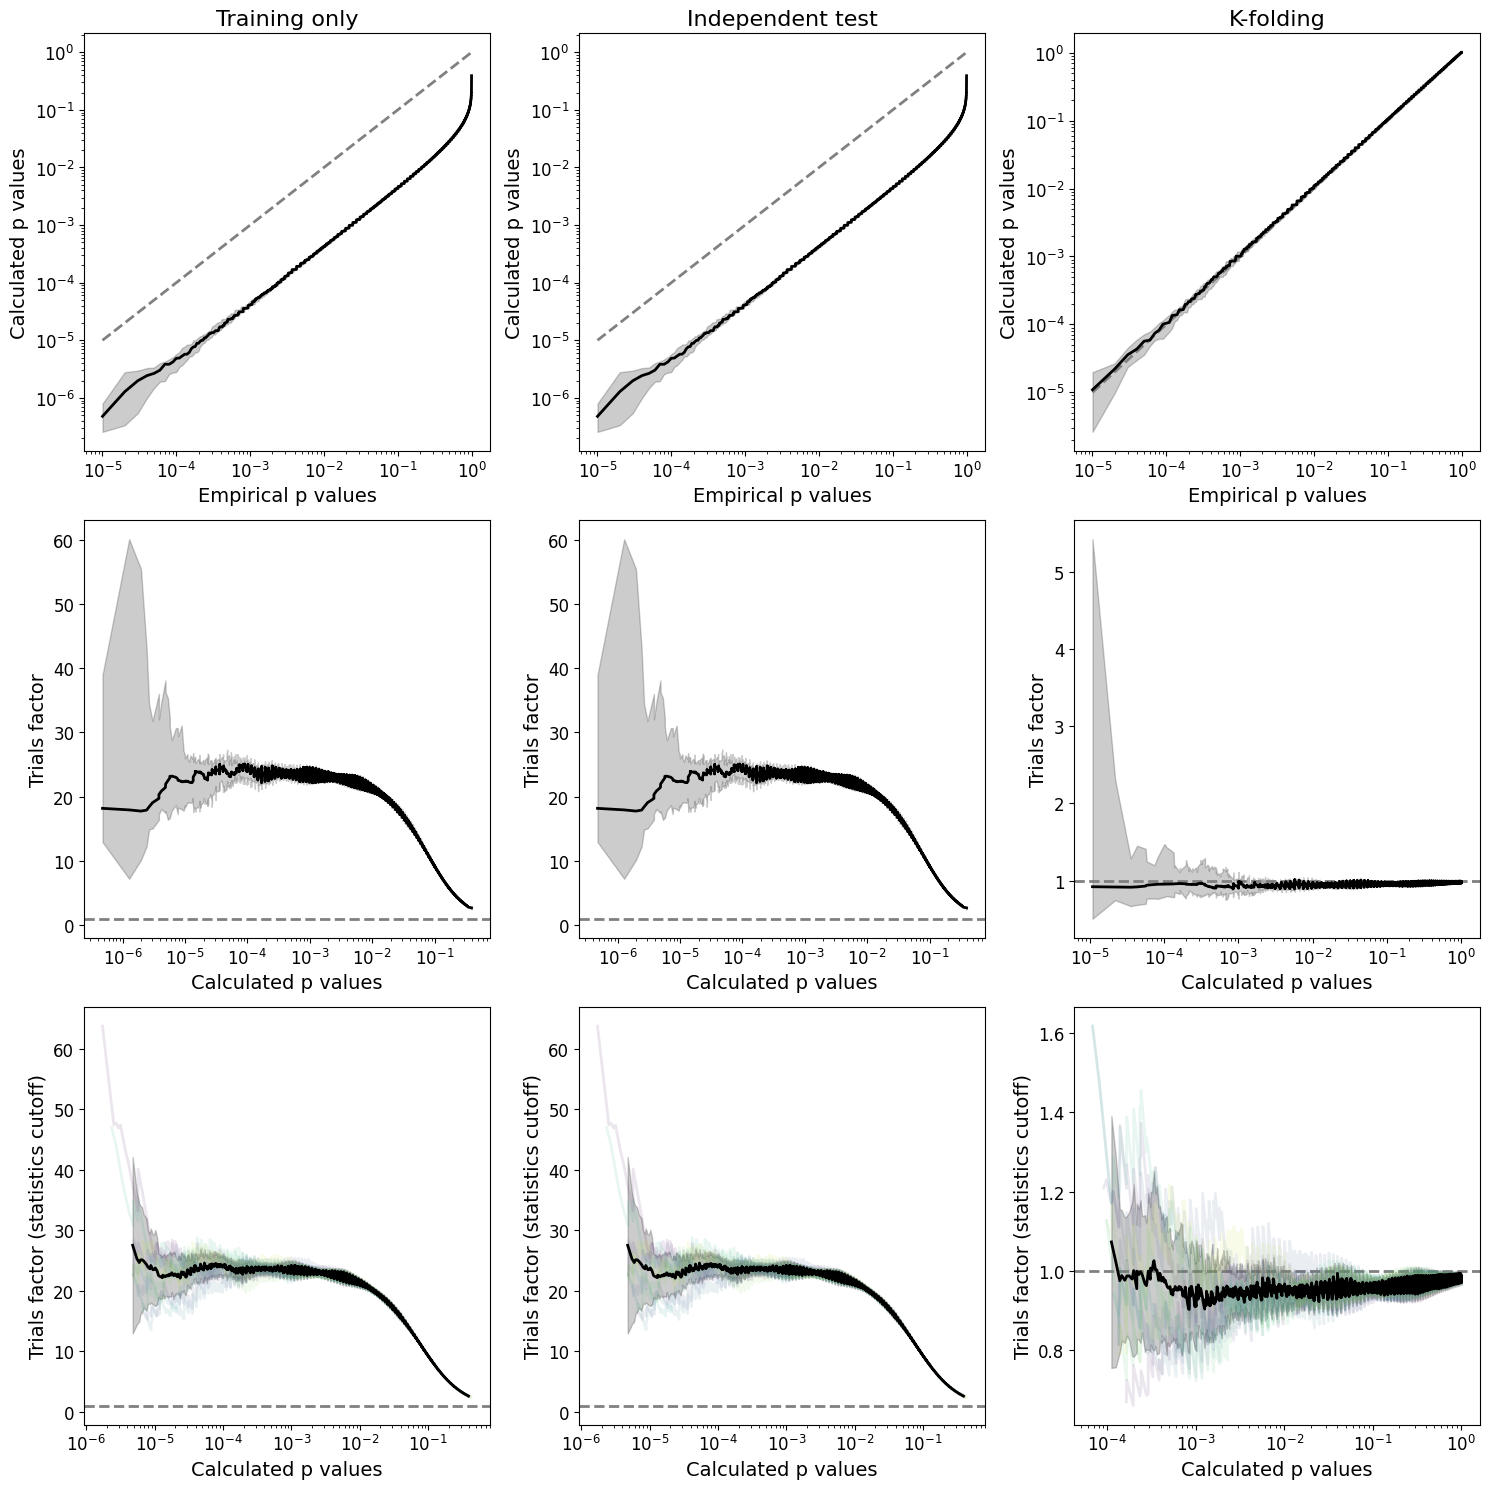

In [9]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
counts = np.arange(1,N_tests+1)/N_tests
bins_plot=np.linspace(0,1,51)


def plot_pvalues(ax, pvalues, counts, title, color="black", mean=False):
    pvalues = np.sort([np.sort(pvalues[i]) for i in range(10)])
    ax[0].plot(counts, np.median(pvalues, axis=0), color=color)
    ax[0].fill_between(counts, np.percentile(pvalues,16, axis=0),np.percentile(pvalues,84, axis=0), color=color, alpha=0.2)
    ax[0].set_title(title)
    
    ax[1].plot(np.median(pvalues, axis=0), gaussian_filter1d(np.median(counts/pvalues, axis=0), sigma=2), color=color)
    ax[1].fill_between(np.median(pvalues, axis=0), np.percentile(counts/pvalues,16, axis=0),np.percentile(counts/pvalues,84, axis=0), color=color, alpha=0.2)

    pvalues = pvalues[:,10:]
    counts = counts[10:]
    m = np.mean(counts/pvalues, axis=0)
    s = np.std(counts/pvalues, axis=0)
    for i in range(10):
        ax[2].plot(pvalues[i], counts/pvalues[i], color=colormap_normal(i/10), alpha=0.1)
    ax[2].plot(np.mean(pvalues, axis=0), m, color=color)
    ax[2].fill_between(np.mean(pvalues, axis=0), m-s,m+s, color=color, alpha=0.2)

for i in range(3):
    ax[0,i].set_xlabel("Empirical p values")
    ax[0,i].set_ylabel("Calculated p values")
    ax[0,i].set_xscale("log")
    ax[0,i].set_yscale("log")
    ax[0,i].plot(counts, counts, color="grey", linestyle="dashed")

    ax[1,i].set_xlabel("Calculated p values")
    ax[1,i].set_ylabel("Trials factor")
    ax[1,i].set_xscale("log")
    ax[1,i].axhline(1, color="grey", linestyle="dashed")

    ax[2,i].set_xlabel("Calculated p values")
    ax[2,i].set_ylabel("Trials factor (statistics cutoff)")
    ax[2,i].set_xscale("log")
    ax[2,i].axhline(1, color="grey", linestyle="dashed")

counts = np.arange(1,N_tests+1)/N_tests
plot_pvalues(ax[:,0], p_train, counts, "Training only")
plot_pvalues(ax[:,1], p_train, counts, "Independent test")
plot_pvalues(ax[:,2], p_test_half, counts, "K-folding")

fig.tight_layout()
fig.savefig("plots/binned_pvalues.pdf")

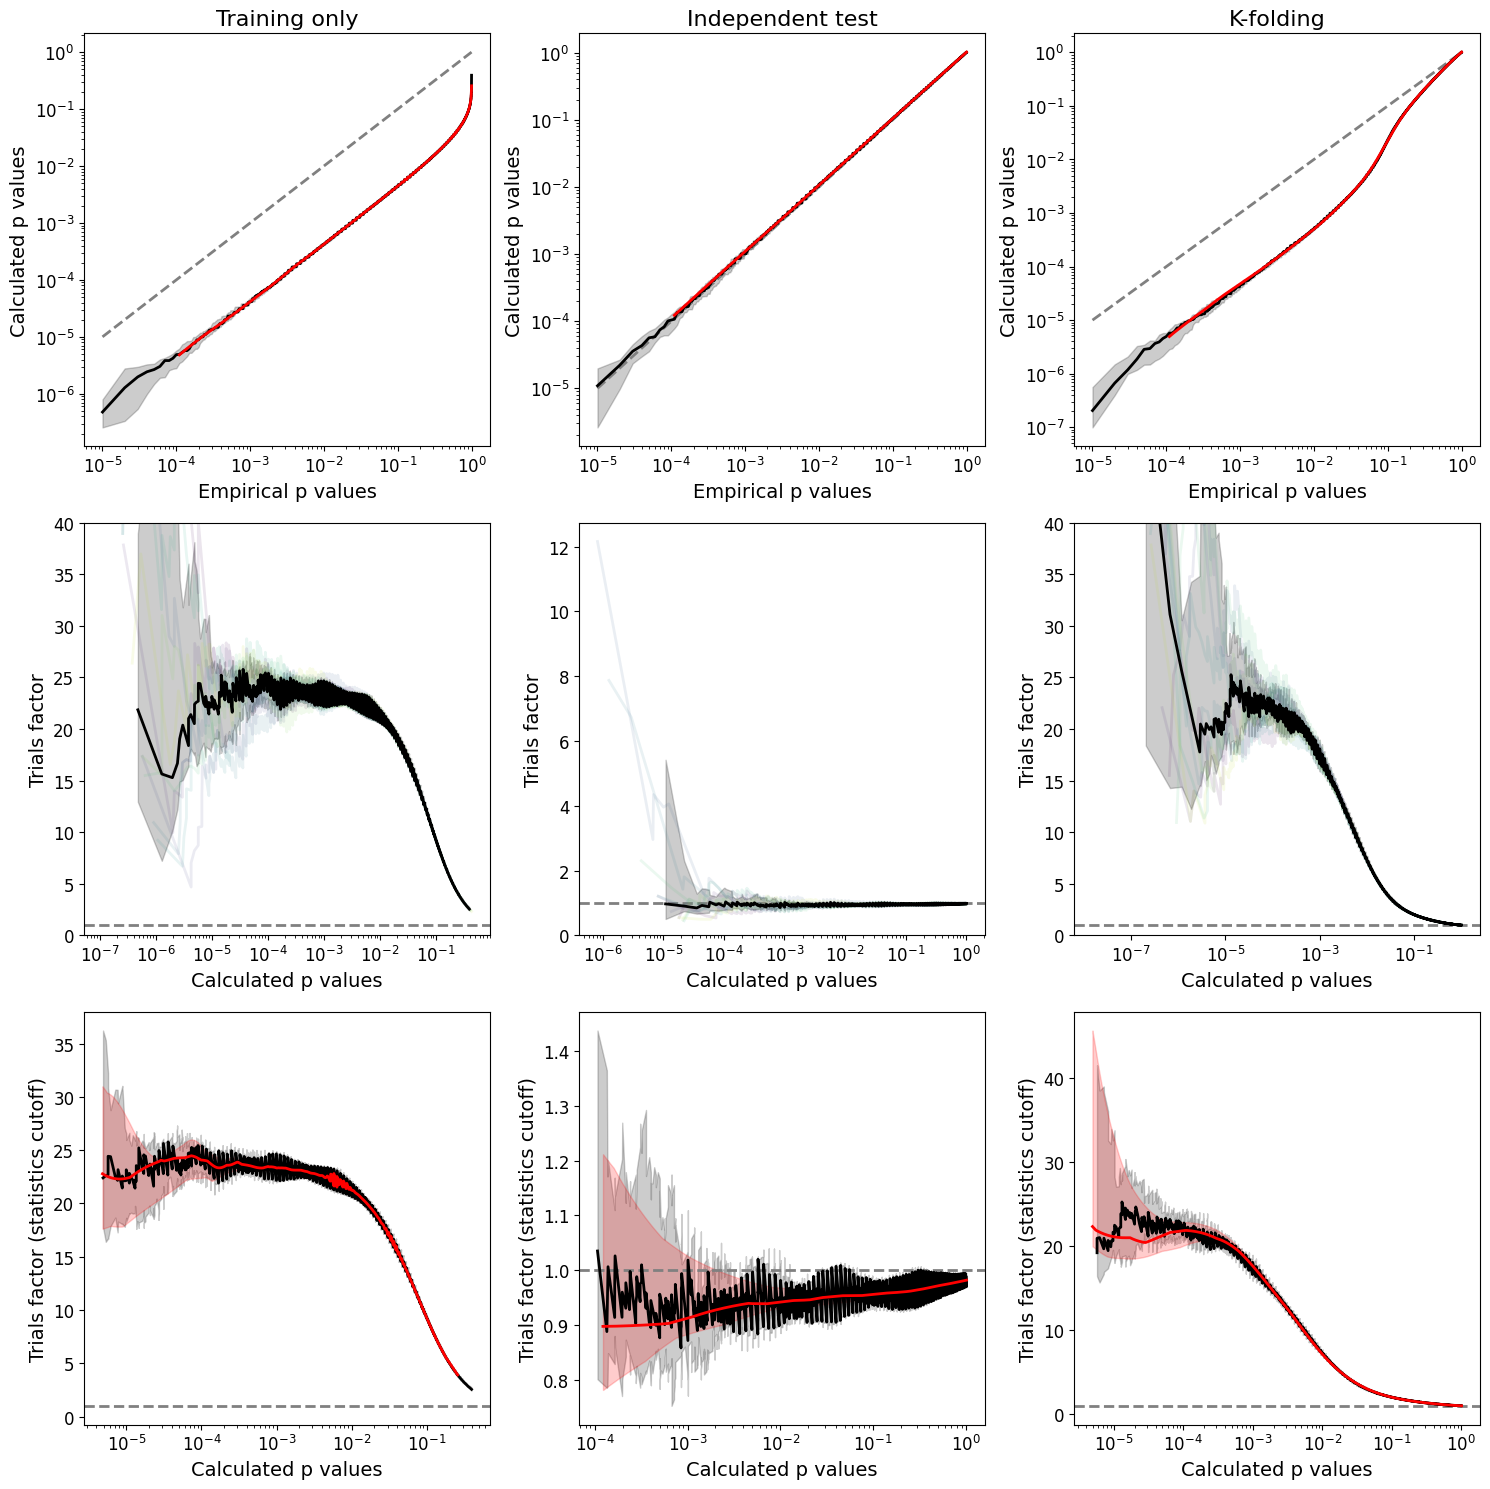

In [11]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
counts = np.arange(1,N_tests+1)/N_tests
bins_plot=np.linspace(0,1,51)
from scipy.interpolate import UnivariateSpline

def moving_average(y, window=50):
    return np.convolve(y, np.ones(window)/window, mode='same')

def plot_pvalues(ax, pvalues, counts, title, color="black", mean=False):

    pvalues = np.sort([np.sort(pvalues[i]) for i in range(10)])

    spline_list = []
    x_fine = np.linspace(np.log10(np.min(counts[10:])), np.log(np.max(counts)), 1000)
    y_smooth = np.zeros((10, len(x_fine)))
    for i in range(10):
        spline_list.append(UnivariateSpline(np.log10(counts[5:]), np.log10(pvalues[i,5:]), s=5))
        y_smooth[i] = spline_list[-1](x_fine)

    ax[0].plot(counts, np.median(pvalues, axis=0), color=color)
    ax[0].fill_between(counts, np.percentile(pvalues,16, axis=0),np.percentile(pvalues,84, axis=0), color=color, alpha=0.2)
    ax[0].set_title(title)
    ax[0].plot(10**x_fine, np.median(10**y_smooth, axis=0), color="red")
    #ax[0].plot(np.median(10**y_smooth, axis=0), 10**x_fine, color="red")

    for i in range(10):
        ax[1].plot(pvalues[i], counts/pvalues[i], color=colormap_normal(i/10), alpha=0.1)
    ax[1].plot(np.median(pvalues, axis=0), np.median(counts/pvalues, axis=0), color=color)
    ax[1].fill_between(np.median(pvalues, axis=0), np.percentile(counts/pvalues,16, axis=0),np.percentile(counts/pvalues,84, axis=0), color=color, alpha=0.2)
    ymin, ymax = ax[1].get_ylim()
    ax[1].set_ylim(0, min(ymax,40))

    pvalues = pvalues[:,10:]
    counts = counts[10:]
    ax[2].plot(np.median(pvalues, axis=0), np.median(counts/pvalues, axis=0), color=color)
    ax[2].fill_between(np.median(pvalues, axis=0), np.percentile(counts/pvalues,16, axis=0),np.percentile(counts/pvalues,84, axis=0), color=color, alpha=0.2)

    ax[2].plot(10**np.median(y_smooth, axis=0), 10**(x_fine-np.median(y_smooth, axis=0)), color="red")
    ax[2].fill_between(np.median(10**(y_smooth), axis=0), 10**(x_fine-np.percentile(y_smooth, 16, axis=0)), 10**(x_fine-np.percentile(y_smooth, 84, axis=0)), color="red", alpha=0.2)
    return spline_list

for i in range(3):
    ax[0,i].set_xlabel("Empirical p values")
    ax[0,i].set_ylabel("Calculated p values")
    ax[0,i].set_xscale("log")
    ax[0,i].set_yscale("log")
    ax[0,i].plot(counts, counts, color="grey", linestyle="dashed")

    ax[1,i].set_xlabel("Calculated p values")
    ax[1,i].set_ylabel("Trials factor")
    ax[1,i].set_xscale("log")
    ax[1,i].axhline(1, color="grey", linestyle="dashed")

    ax[2,i].set_xlabel("Calculated p values")
    ax[2,i].set_ylabel("Trials factor (statistics cutoff)")
    ax[2,i].set_xscale("log")
    ax[2,i].axhline(1, color="grey", linestyle="dashed")

counts = np.arange(1,N_tests+1)/N_tests
splines_train = plot_pvalues(ax[:,0], p_train, counts, "Training only")
splines_test = plot_pvalues(ax[:,1], p_test_half, counts, "Independent test")
splines_kfold = plot_pvalues(ax[:,2], p_kfold, counts, "K-folding")    

fig.tight_layout()
fig.savefig("plots/binned_pvalues.pdf")

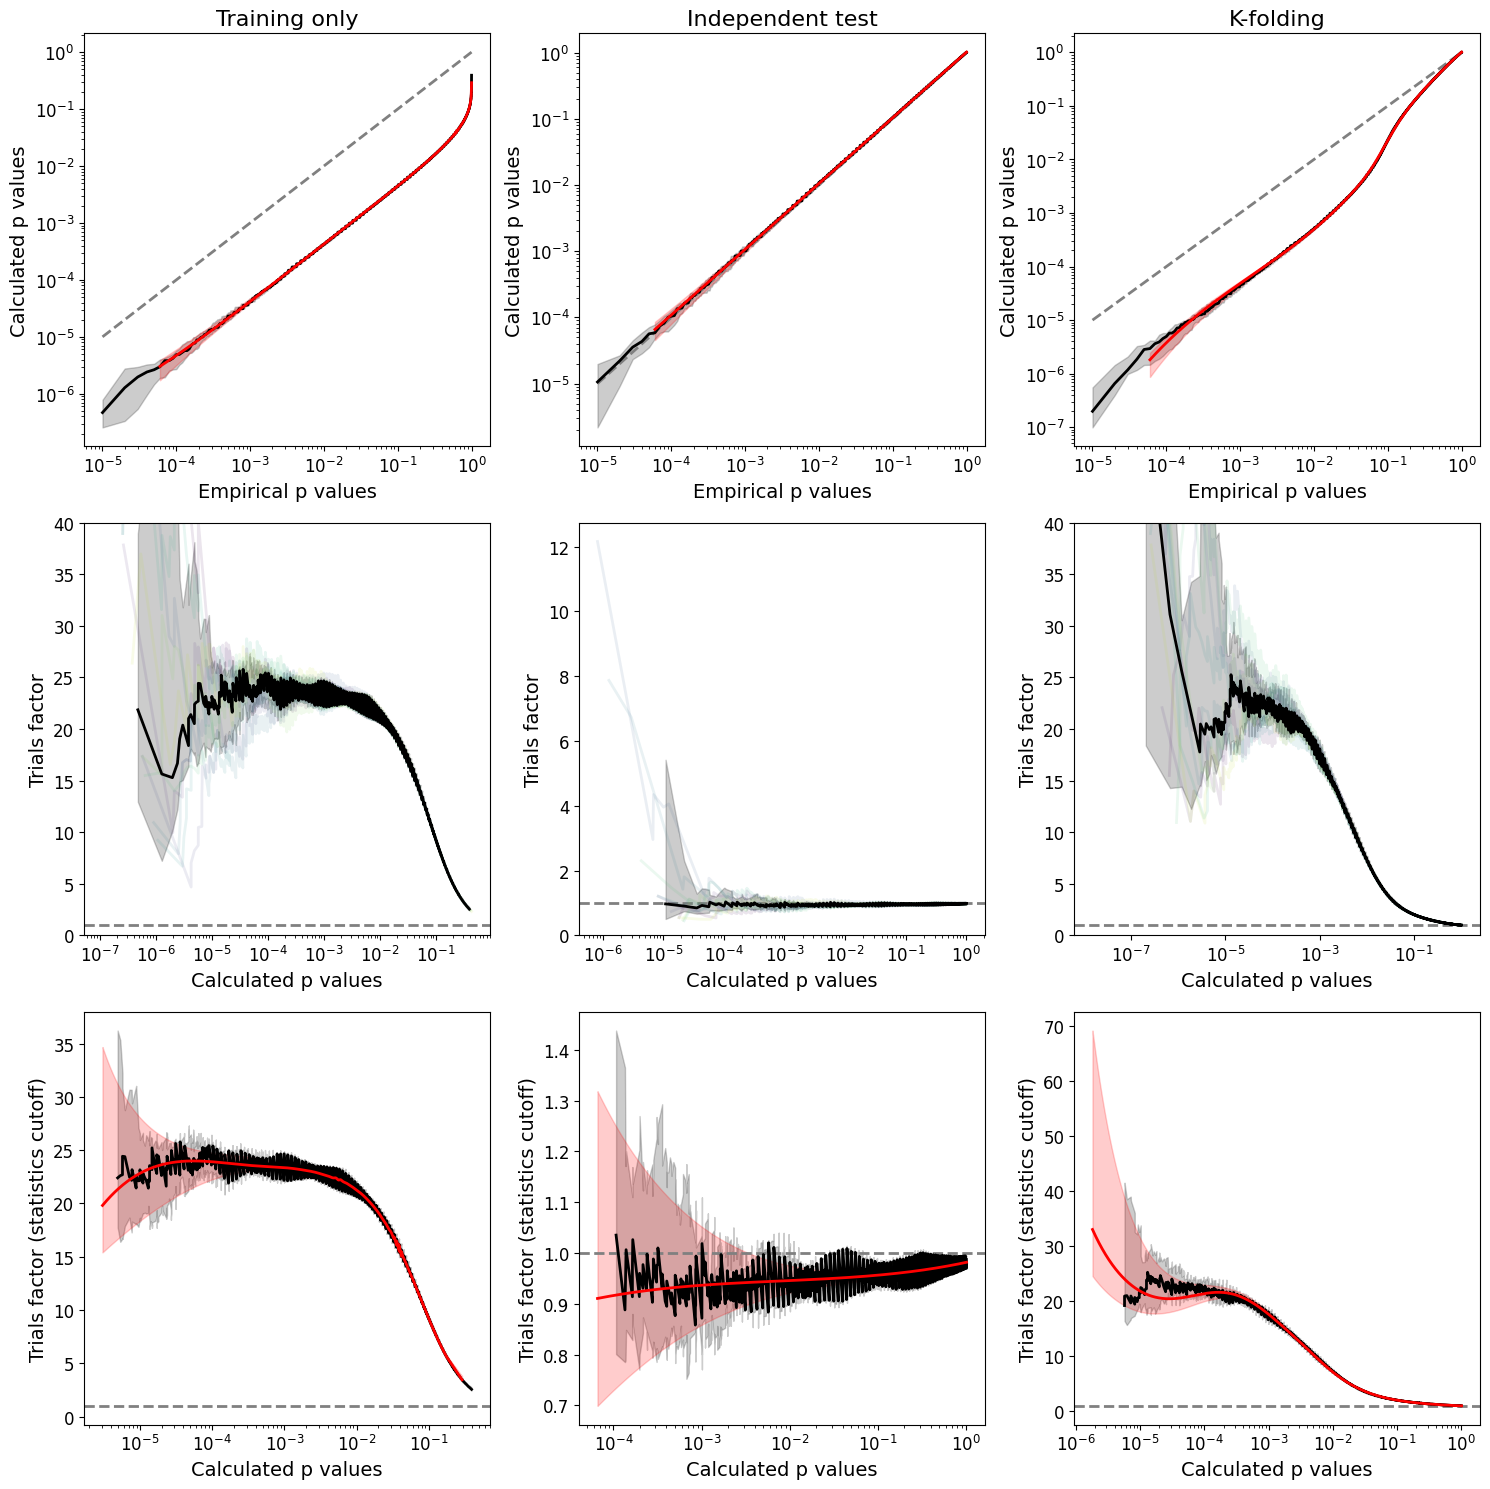

In [12]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
counts = np.arange(1,N_tests+1)/N_tests
bins_plot=np.linspace(0,1,51)
from scipy.interpolate import UnivariateSpline

def moving_average(y, window=50):
    return np.convolve(y, np.ones(window)/window, mode='same')

def plot_pvalues(ax, pvalues, counts, title, color="black", mean=False, start=5):

    pvalues = np.sort([np.sort(pvalues[i]) for i in range(10)])

    s=5
    x_fine = np.linspace(np.log10(np.min(counts[start:])), np.log10(np.max(counts)), 1000)
    spline_median = UnivariateSpline(np.log10(counts[start:]), np.median(np.log10(pvalues[:,start:]), axis=0), s=s)
    spline_upper = UnivariateSpline(np.log10(counts[start:]), np.percentile(np.log10(pvalues[:,start:]), 84, axis=0), s=s)
    spline_lower = UnivariateSpline(np.log10(counts[start:]), np.percentile(np.log10(pvalues[:,start:]), 16, axis=0), s=s)
    y_median = spline_median(x_fine)
    y_upper = spline_upper(x_fine)
    y_lower = spline_lower(x_fine)

    ax[0].plot(counts, 10**np.median(np.log10(pvalues), axis=0), color=color)
    ax[0].fill_between(counts, 10**np.percentile(np.log10(pvalues),16, axis=0),10**np.percentile(np.log10(pvalues),84, axis=0), color=color, alpha=0.2)
    ax[0].set_title(title)
    ax[0].plot(10**x_fine, 10**y_median, color="red")
    ax[0].fill_between(10**x_fine, 10**y_lower, 10**y_upper, color="red", alpha=0.2)
    #ax[0].plot(np.median(10**y_smooth, axis=0), 10**x_fine, color="red")

    for i in range(10):
        ax[1].plot(pvalues[i], counts/pvalues[i], color=colormap_normal(i/10), alpha=0.1)
    ax[1].plot(np.median(pvalues, axis=0), np.median(counts/pvalues, axis=0), color=color)
    ax[1].fill_between(np.median(pvalues, axis=0), np.percentile(counts/pvalues,16, axis=0),np.percentile(counts/pvalues,84, axis=0), color=color, alpha=0.2)
    ymin, ymax = ax[1].get_ylim()
    ax[1].set_ylim(0, min(ymax,40))

    pvalues = pvalues[:,10:]
    counts = counts[10:]
    ax[2].plot(np.median(pvalues, axis=0), np.median(counts/pvalues, axis=0), color=color)
    ax[2].fill_between(np.median(pvalues, axis=0), np.percentile(counts/pvalues,16, axis=0),np.percentile(counts/pvalues,84, axis=0), color=color, alpha=0.2)

    ax[2].plot(10**y_median, 10**(x_fine-y_median), color="red")
    ax[2].fill_between(10**(y_median), 10**(x_fine-y_upper), 10**(x_fine-y_lower), color="red", alpha=0.2)
    return x_fine, {"Median": y_median, "Upper": y_upper, "Lower": y_lower}, 

for i in range(3):
    ax[0,i].set_xlabel("Empirical p values")
    ax[0,i].set_ylabel("Calculated p values")
    ax[0,i].set_xscale("log")
    ax[0,i].set_yscale("log")
    ax[0,i].plot(counts, counts, color="grey", linestyle="dashed")

    ax[1,i].set_xlabel("Calculated p values")
    ax[1,i].set_ylabel("Trials factor")
    ax[1,i].set_xscale("log")
    ax[1,i].axhline(1, color="grey", linestyle="dashed")

    ax[2,i].set_xlabel("Calculated p values")
    ax[2,i].set_ylabel("Trials factor (statistics cutoff)")
    ax[2,i].set_xscale("log")
    ax[2,i].axhline(1, color="grey", linestyle="dashed")

counts = np.arange(1,N_tests+1)/N_tests
x_train, ys_train = plot_pvalues(ax[:,0], p_train, counts, "Training only")
x_test, ys_test = plot_pvalues(ax[:,1], p_test_half, counts, "Independent test")
x_kfold, ys_kfold = plot_pvalues(ax[:,2], p_kfold, counts, "K-folding")    

fig.tight_layout()
fig.savefig("plots/binned_pvalues.pdf")

# Look for signals

In [25]:
def oned_sample(N, rv):
    x = rv.rvs(N).reshape((N,1))
    y = rv.rvs(N).reshape((N,1))
    return np.concatenate((x,y), axis=1)

def p_value_binomial(N_data, N_BT, N_total):
    p_value = 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)
    p_left = stats.binom.cdf(N_data, N_total, N_BT/N_total) 
    return np.min(np.array([p_value, p_left]), axis=0)*2

def evaluate_on_train(data, N, rv_bkg, bins, bins_edge = None):
    exp = np.zeros((bins,bins))
    edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv_bkg.cdf(edges[0][i+1])*rv_bkg.cdf(edges[1][j+1])+rv_bkg.cdf(edges[0][i])*rv_bkg.cdf(edges[1][j]) - rv_bkg.cdf(edges[0][i+1])*rv_bkg.cdf(edges[1][j])-rv_bkg.cdf(edges[0][i])*rv_bkg.cdf(edges[1][j+1]))*N

    p_train = np.zeros((bins,bins))
    hist_train = np.histogramdd(data, bins=edges)[0]
    p_train = p_value_binomial(hist_train, exp, N)
    return np.min(p_train)

def evaluate_on_test(data, N, rv_bkg, bins, bins_edge = None):
    exp = np.zeros((bins,bins))
    edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv_bkg.cdf(edges[0][i+1])*rv_bkg.cdf(edges[1][j+1])+rv_bkg.cdf(edges[0][i])*rv_bkg.cdf(edges[1][j]) - rv_bkg.cdf(edges[0][i+1])*rv_bkg.cdf(edges[1][j])-rv_bkg.cdf(edges[0][i])*rv_bkg.cdf(edges[1][j+1]))*N

    p_train = np.zeros((bins,bins))
    data_train, data_test = np.array_split(data, 2, axis=0)
    hist_train = np.histogramdd(data_train, bins=edges)[0]
    hist_test = np.histogramdd(data_test, bins=edges)[0]
    p_train = p_value_binomial(hist_train, exp/2, N//2)
    min_ind = np.argmin(p_train.flatten())
    #p_test = p_value_binomial(hist_test.flatten()[min_ind], exp.flatten()[min_ind]/2, N//2)
    #print(p_train.flatten()[min_ind], p_test, np.min(p_train))
    return p_value_binomial(hist_test.flatten()[min_ind], exp.flatten()[min_ind]/2, N//2)

def evaluate_with_kfolds(data, N, rv_bkg, bins, bins_edge = None, folds=5):
    exp = np.zeros((bins,bins))
    edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv_bkg.cdf(edges[0][i+1])*rv_bkg.cdf(edges[1][j+1])+rv_bkg.cdf(edges[0][i])*rv_bkg.cdf(edges[1][j]) - rv_bkg.cdf(edges[0][i+1])*rv_bkg.cdf(edges[1][j])-rv_bkg.cdf(edges[0][i])*rv_bkg.cdf(edges[1][j+1]))*N

    hist = np.zeros((bins,bins, folds))
    N_test = np.zeros((folds))
    exp_test = np.zeros((folds))
    best_bin = np.zeros((folds), dtype=int)

    data = np.array_split(data, 5, axis=0)
    for m in range(folds):
        hist[:,:,m] = np.histogramdd(data[m],bins=edges)[0]

    for m in range(folds):
        inds = np.roll(np.array(range(folds)), m)
        p_only_train = p_value_binomial(np.sum(hist[:,:,inds[:-1]],axis=-1), exp*(folds-1)/folds, N*(folds-1)/folds).flatten()
        best_bin[m] = np.argmin(p_only_train)
        N_test[m] = hist[:,:,inds[-1]].flatten()[best_bin[m]]
        exp_test[m] = exp.flatten()[best_bin[m]]/5

    return p_value_binomial(np.sum(N_test), np.sum(exp_test), N)

def adjust_pvalues(pvalues, ys, x):
    adjusted = 10**interp1d(ys["Median"], x, bounds_error=False, fill_value=(x[0], x[-1]))(np.log10(pvalues).flatten())
    adjusted = np.max([pvalues.flatten(), adjusted], axis=0)
    return adjusted.reshape(pvalues.shape)

bins_edge = 5
rv = stats.uniform(loc=-bins_edge, scale=2*bins_edge)

widths = [0.1, 0.3, 0.5, 1, 2]
positions = [0,1]
amounts = [0,50,100, 150, 200, 250, 500, 1000, 2000,3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

pvalues_train = np.zeros((len(widths), len(positions), len(amounts), 10))
pvalues_test = np.zeros((len(widths), len(positions), len(amounts), 10))
pvalues_kfold = np.zeros((len(widths), len(positions), len(amounts), 10))

for i,w in enumerate(widths):
    for j,p in enumerate(positions):
        rv_signal = multivariate_normal(mean=[p,p], cov=[[w,0],[0,w]])
        for k,a in enumerate(amounts):
            for m in range(10):
                data = np.concatenate((oned_sample(N-a, rv), rv_signal.rvs(a)), axis=0)
                np.random.shuffle(data)
                pvalues_train[i,j,k,m] = evaluate_on_train(data, N, rv, 5, bins_edge)
                pvalues_test[i,j,k,m] = evaluate_on_test(data, N, rv, 5, bins_edge)
                pvalues_kfold[i,j,k,m] = evaluate_with_kfolds(data, N, rv, 5, bins_edge, folds=5)

pvalues_train_adjusted = adjust_pvalues(pvalues_train, ys_train, x_train)
pvalues_test_adjusted = adjust_pvalues(pvalues_test, ys_test, x_test)
pvalues_kfold_adjusted = adjust_pvalues(pvalues_kfold, ys_kfold, x_kfold)


print(directory+"signals/p_train_adjusted.npy")
np.save(directory+"signals/p_train_adjusted.npy", np.array(pvalues_train_adjusted))
np.save(directory+"signals/p_train.npy", np.array(pvalues_train))
np.save(directory+"signals/p_test_adjusted.npy", np.array(pvalues_test_adjusted))
np.save(directory+"signals/p_test.npy", np.array(pvalues_test))
np.save(directory+"signals/p_kfolds_adjusted.npy", np.array(pvalues_kfold_adjusted))
np.save(directory+"signals/p_kfolds.npy", np.array(pvalues_kfold))

/hpcwork/zu992399/look_elsewhere/binned_test/signals/p_train_adjusted.npy


/tmp/zu992399/login23-3_82949/ipykernel_246564/215076000.py:66: RuntimeWarning: divide by zero encountered in log10
  adjusted = 10**interp1d(ys["Median"], x, bounds_error=False, fill_value=(x[0], x[-1]))(np.log10(pvalues).flatten())


-4.221848749616356


TypeError: list indices must be integers or slices, not tuple

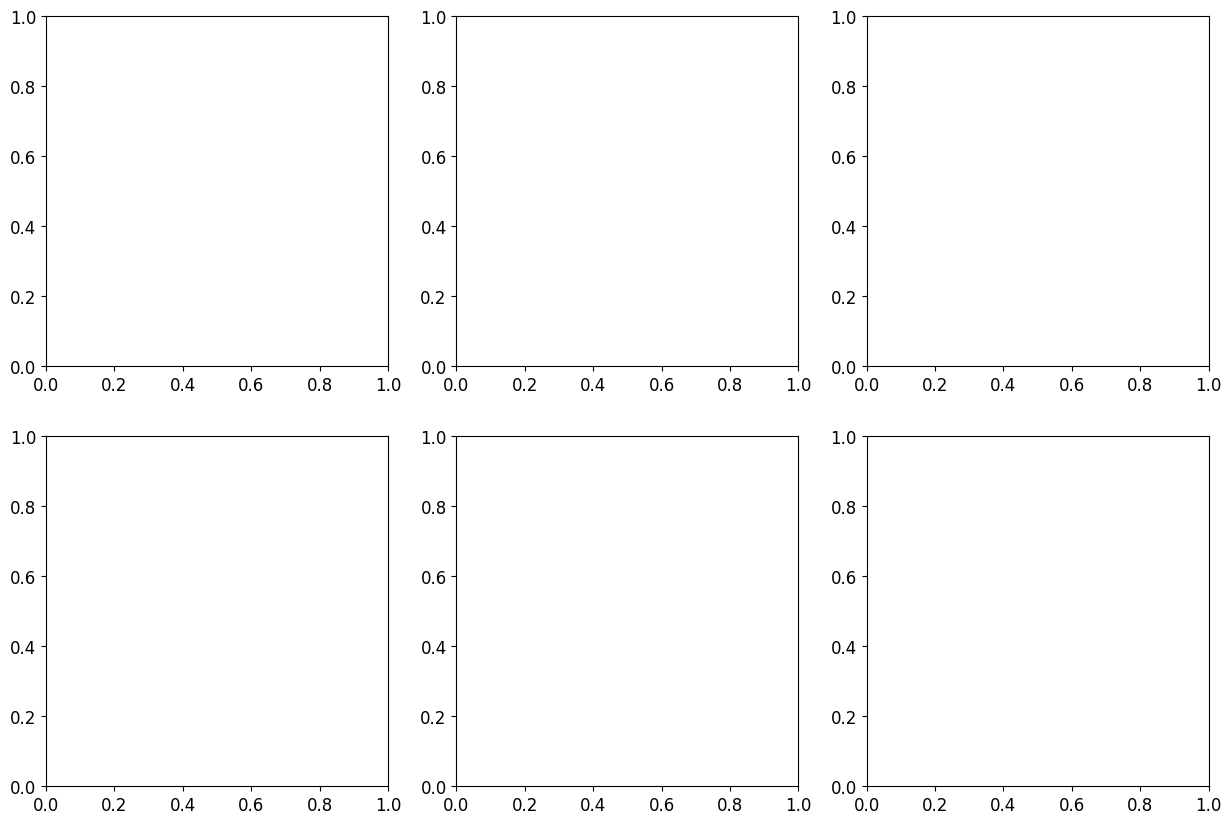

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
ticks_pre = []
ticks_post = []
print(x_kfold[0])
for k,a in enumerate(amounts[np.array([0,3,5]]):
    ax[k].axhline(1, color="black", linestyle="solid", label=r"0$\sigma$")
    ax[k].axhline(sigma3, color="black", linestyle="dashed", label=r"3$\sigma$")
    ax[k].axhline(sigma5, color="black", linestyle="dotted", label=r"5$\sigma$")
    #ax[k].axhline(10**x_kfold[0], color="black", linestyle="dashdot", label="Min plotted")
    for i,w in enumerate(widths):
        for j,p in enumerate(positions):
            if i==0 and j==0:
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_train[i,j,k]), color="black", label="Training only", marker="o")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_test[i,j,k]), color="red",  marker="^", label="Independent test")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_kfold[i,j,k]), color="blue",  marker="s", label="K-folding")
            else:
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_train[i,j,k]), color="black",  marker="o")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_test[i,j,k]), color="red",  marker="^")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_kfold[i,j,k]), color="blue",  marker="s")
            if k==0:
                ticks_pre = np.append(ticks_pre, i*len(positions)+j)
                ticks_post = np.append(ticks_post, r"$\mu=$"+str(p)+r", $\sigma=$"+str(w))
    _ = ax[k].set_xticks(ticks_pre, ticks_post, rotation=45)
    ax[k].set_yscale("log")
    ax[k].set_title(str(a)+" signal events")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("Uncorrected p-values", fontsize=16)
fig.set_tight_layout("tight")


-4.221848749616356


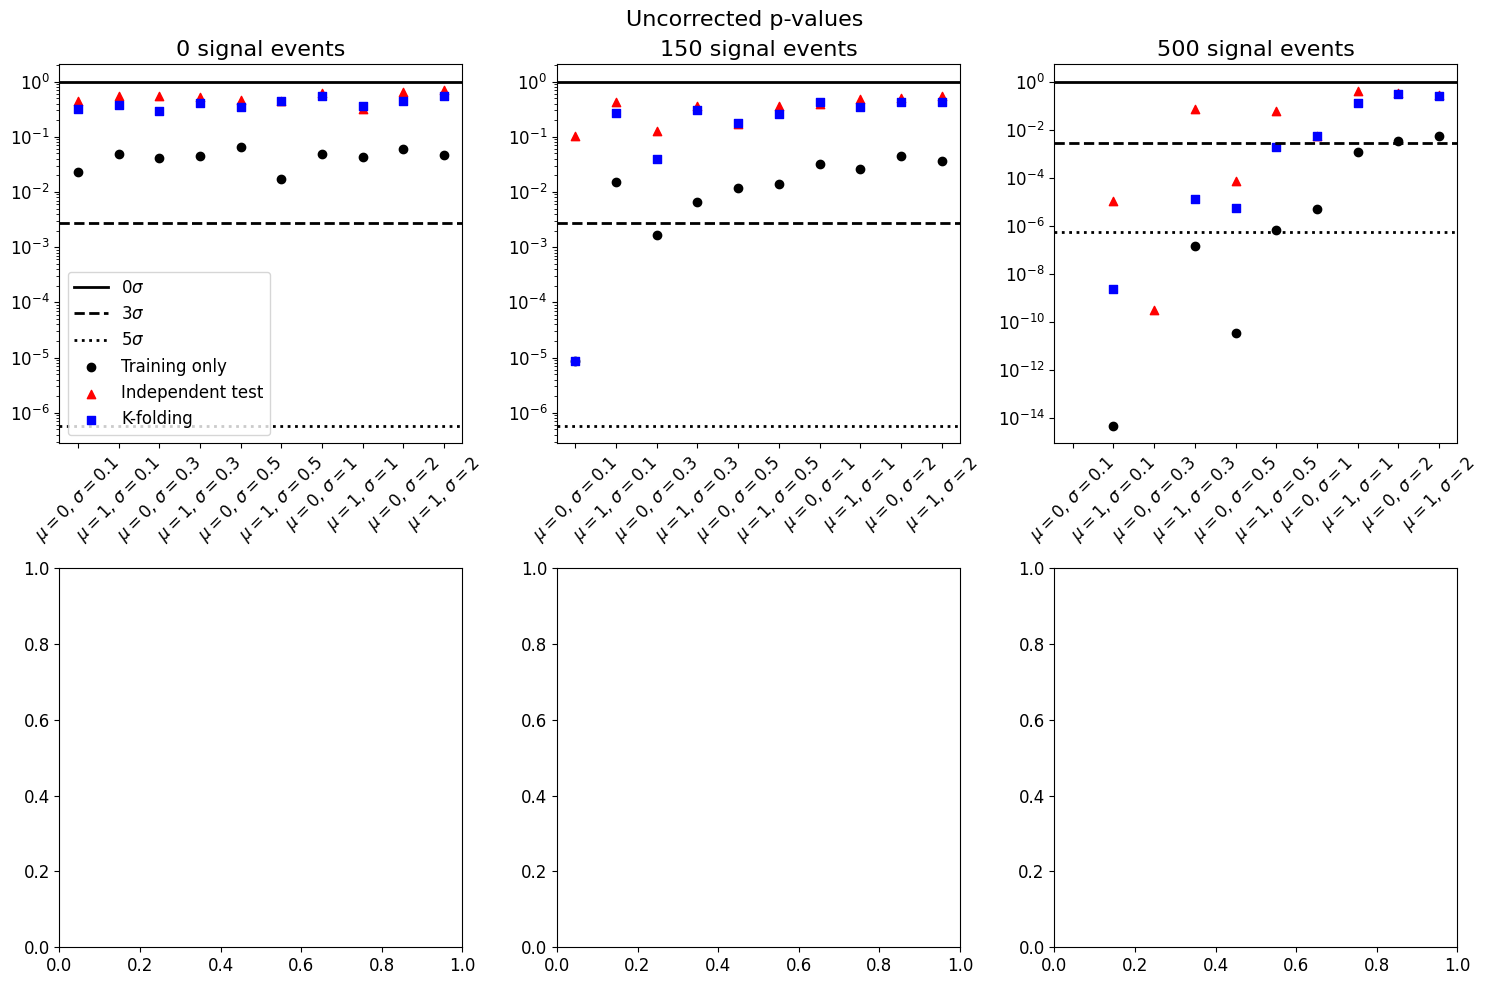

In [36]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
ticks_pre = []
ticks_post = []
print(x_kfold[0])
for k,m in enumerate([0,3,6]):
    a = amounts[m]
    ax[k].axhline(1, color="black", linestyle="solid", label=r"0$\sigma$")
    ax[k].axhline(sigma3, color="black", linestyle="dashed", label=r"3$\sigma$")
    ax[k].axhline(sigma5, color="black", linestyle="dotted", label=r"5$\sigma$")
    #ax[k].axhline(10**x_kfold[0], color="black", linestyle="dashdot", label="Min plotted")
    for i,w in enumerate(widths):
        for j,p in enumerate(positions):
            if i==0 and j==0:
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_train[i,j,m]), color="black", label="Training only", marker="o")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_test[i,j,m]), color="red",  marker="^", label="Independent test")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_kfold[i,j,m]), color="blue",  marker="s", label="K-folding")
            else:
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_train[i,j,m]), color="black",  marker="o")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_test[i,j,m]), color="red",  marker="^")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_kfold[i,j,m]), color="blue",  marker="s")
            if k==0:
                ticks_pre = np.append(ticks_pre, i*len(positions)+j)
                ticks_post = np.append(ticks_post, r"$\mu=$"+str(p)+r", $\sigma=$"+str(w))
    _ = ax[k].set_xticks(ticks_pre, ticks_post, rotation=45)
    ax[k].set_yscale("log")
    ax[k].set_title(str(a)+" signal events")
ax[0].legend(loc='lower left')
fig.suptitle("Uncorrected p-values", fontsize=16)
fig.set_tight_layout("tight")


-4.221848749616356


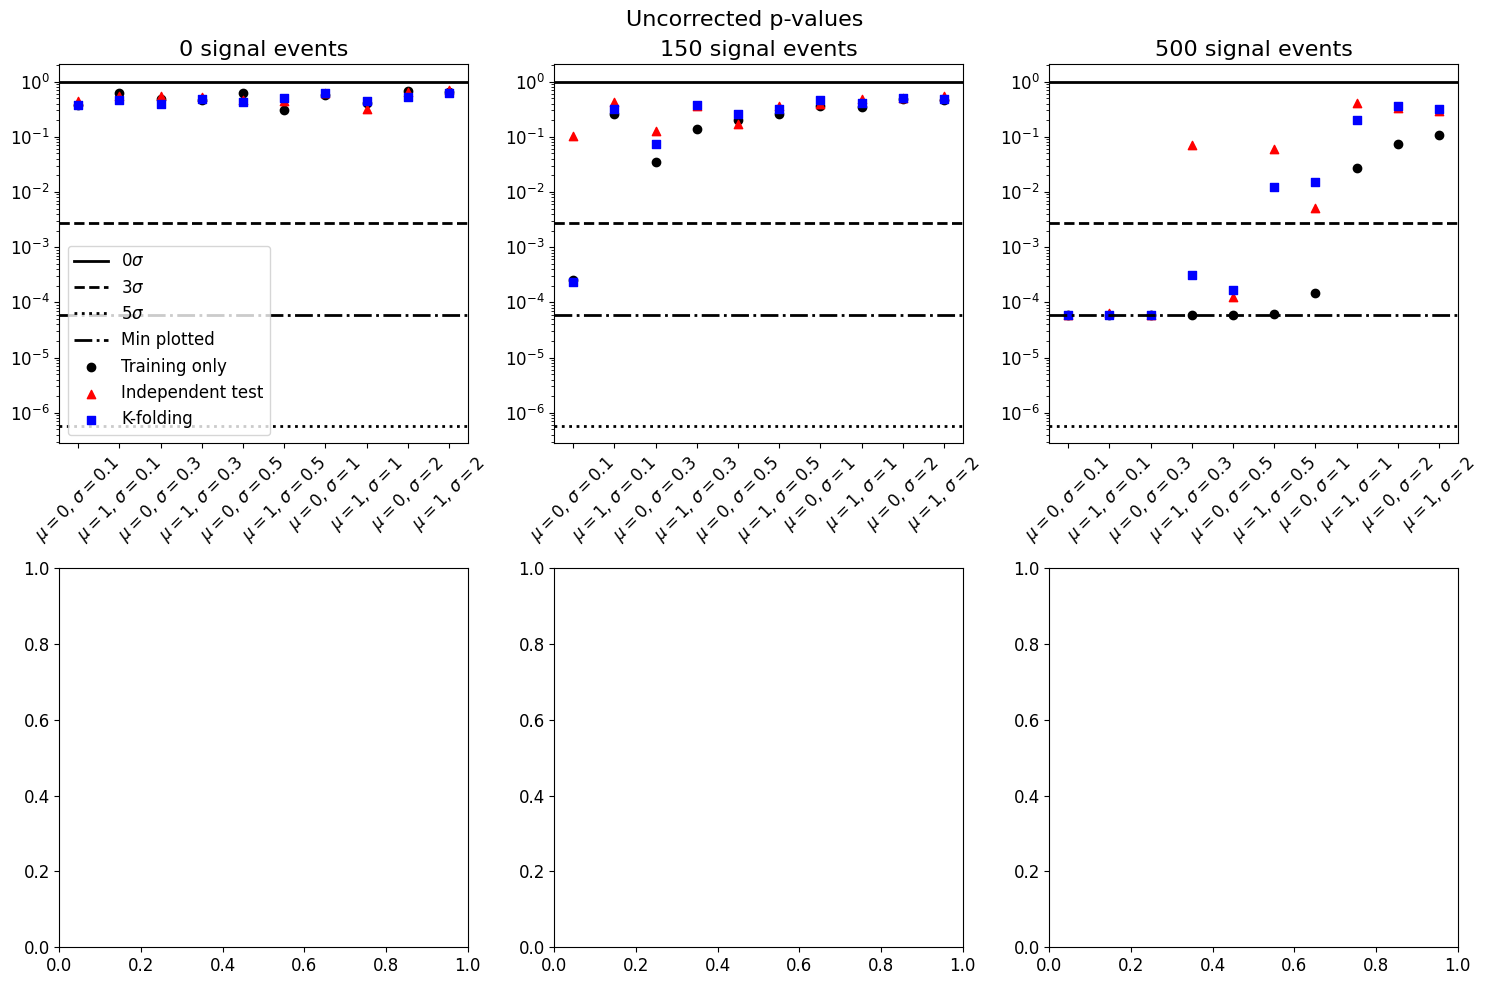

In [38]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
ticks_pre = []
ticks_post = []
print(x_kfold[0])
for k,m in enumerate([0,3,6]):
    a = amounts[m]
    ax[k].axhline(1, color="black", linestyle="solid", label=r"0$\sigma$")
    ax[k].axhline(sigma3, color="black", linestyle="dashed", label=r"3$\sigma$")
    ax[k].axhline(sigma5, color="black", linestyle="dotted", label=r"5$\sigma$")
    ax[k].axhline(10**x_kfold[0], color="black", linestyle="dashdot", label="Min plotted")
    for i,w in enumerate(widths):
        for j,p in enumerate(positions):
            if i==0 and j==0:
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_train_adjusted[i,j,m]), color="black", label="Training only", marker="o")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_test_adjusted[i,j,m]), color="red",  marker="^", label="Independent test")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_kfold_adjusted[i,j,m]), color="blue",  marker="s", label="K-folding")
            else:
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_train_adjusted[i,j,m]), color="black",  marker="o")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_test_adjusted[i,j,m]), color="red",  marker="^")
                ax[k].scatter(i*len(positions)+j,np.mean(pvalues_kfold_adjusted[i,j,m]), color="blue",  marker="s")
            if k==0:
                ticks_pre = np.append(ticks_pre, i*len(positions)+j)
                ticks_post = np.append(ticks_post, r"$\mu=$"+str(p)+r", $\sigma=$"+str(w))
    _ = ax[k].set_xticks(ticks_pre, ticks_post, rotation=45)
    ax[k].set_yscale("log")
    ax[k].set_title(str(a)+" signal events")
ax[0].legend(loc='lower left')
fig.suptitle("Uncorrected p-values", fontsize=16)
fig.set_tight_layout("tight")


IndexError: index 6 is out of bounds for axis 0 with size 6

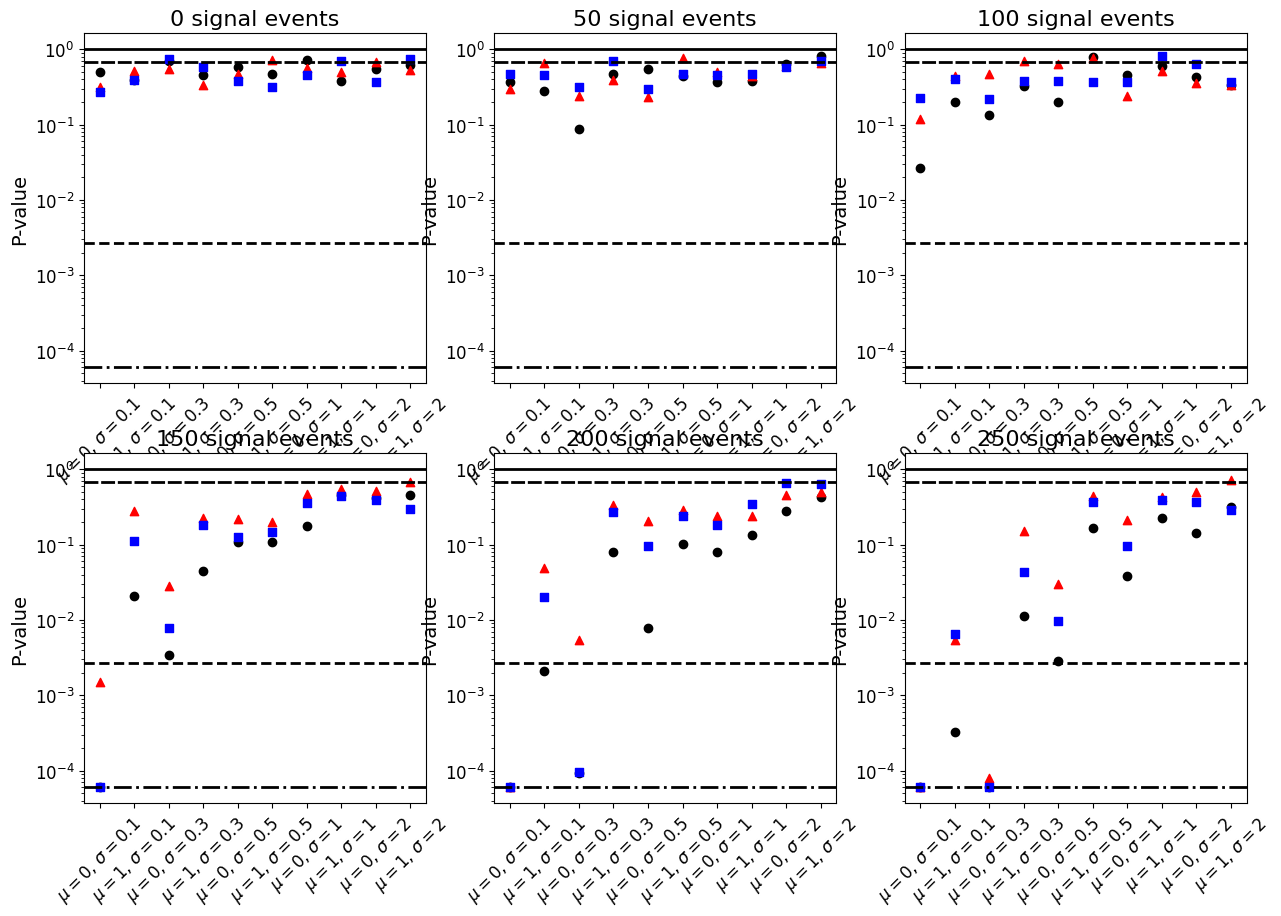

In [22]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
ticks_pre = []
ticks_post = []

def plot(ax, x, p, color, marker, label=None):
    med = 10**np.median(np.log10(p))
    err_lower = med-10**np.percentile(np.log10(p), 16)
    err_upper = -med+10**np.percentile(np.log10(p), 84)
    ax.scatter(x, med, color=color, marker=marker, label=label)

for k,a in enumerate(amounts):
    ax[k].axhline(1, color="black", linestyle="solid", label=r"0$\sigma$")
    ax[k].axhline(0.68, color="black", linestyle=(0, (5, 1)), label=r"1$\sigma$")
    ax[k].axhline(sigma3, color="black", linestyle="dashed", label=r"3$\sigma$")
    ax[k].axhline(10**x_kfold[0], color="black", linestyle="dashdot", label="Min plotted")
    #plt.axhline(5.7*1e-7, color="black", linestyle="dotted", label=r"5$\sigma$")
    for i,w in enumerate(widths):
        for j,p in enumerate(positions):
            if i==0 and j==0:
                plot(ax[k], i*len(positions)+j, pvalues_train_adjusted[i,j,k], "black", "o", label="Training only")
                plot(ax[k], i*len(positions)+j, pvalues_test_adjusted[i,j,k], "red", "^", label="Independent test")
                plot(ax[k], i*len(positions)+j, pvalues_kfold_adjusted[i,j,k], "blue", "s", label="K-folding")
            else:
                plot(ax[k], i*len(positions)+j, pvalues_train_adjusted[i,j,k], "black", "o")
                plot(ax[k], i*len(positions)+j, pvalues_test_adjusted[i,j,k], "red", "^")
                plot(ax[k], i*len(positions)+j, pvalues_kfold_adjusted[i,j,k], "blue", "s")
            if k==0:
                ticks_pre = np.append(ticks_pre, i*len(positions)+j)
                ticks_post = np.append(ticks_post, r"$\mu=$"+str(p)+r", $\sigma=$"+str(w))
    _ = ax[k].set_xticks(ticks_pre, ticks_post, rotation=45)
    ax[k].set_yscale("log")
    ax[k].set_title(str(a)+" signal events")
    ax[k].set_ylabel("P-value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("Corrected p-values", fontsize=16)
fig.set_tight_layout("tight")

IndexError: index 6 is out of bounds for axis 0 with size 6

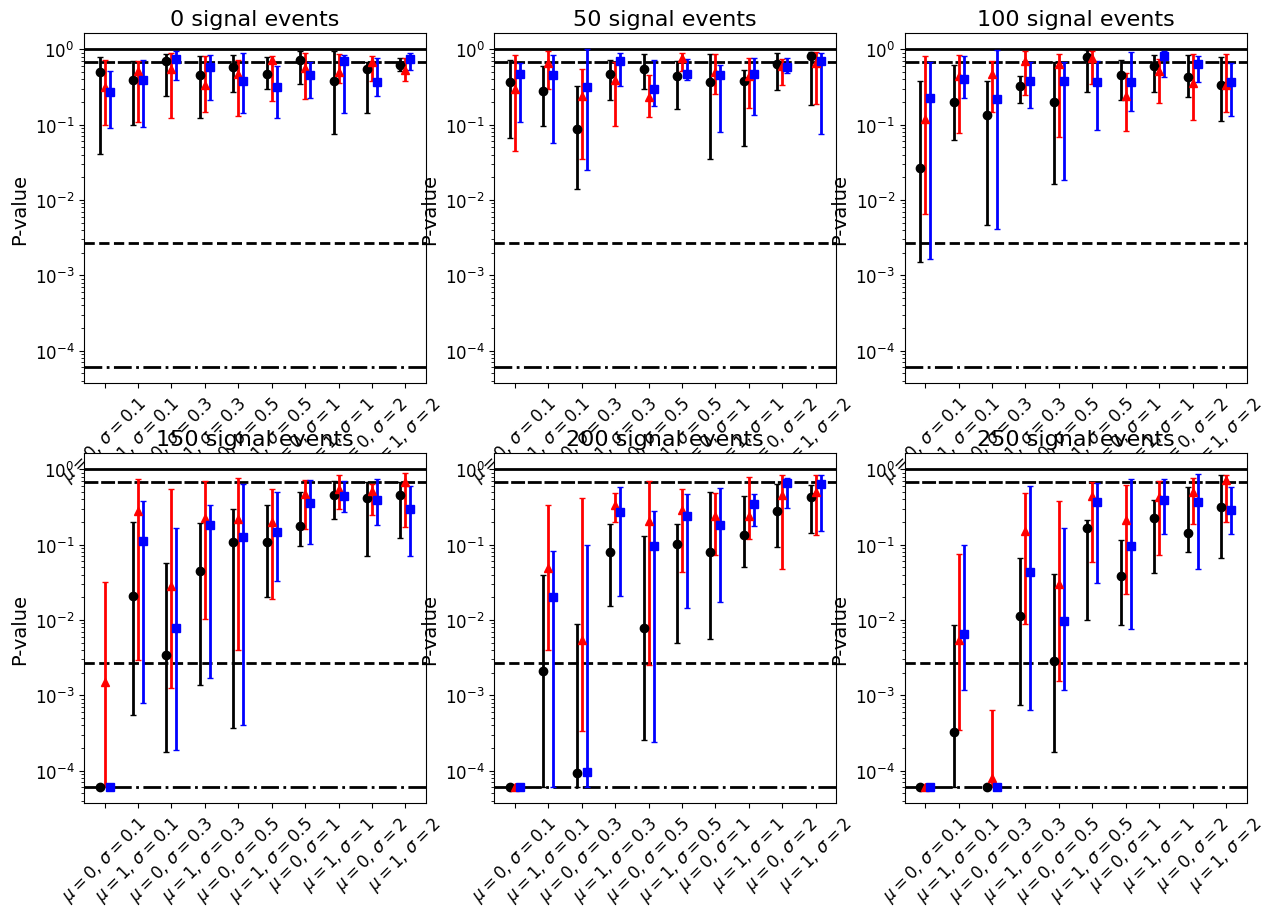

In [23]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
ticks_pre = []
ticks_post = []

def plot(ax, n, x, p, color, marker, label=None):
    med = 10**np.median(np.log10(p))
    err_lower = med-10**np.percentile(np.log10(p), 16)
    err_upper = -med+10**np.percentile(np.log10(p), 84)
    ax.errorbar(x+(n-1)*0.15, med, [[err_lower], [err_upper]], color=color, marker=marker, label=label)

for k,a in enumerate(amounts):
    ax[k].axhline(1, color="black", linestyle="solid", label=r"0$\sigma$")
    ax[k].axhline(0.68, color="black", linestyle=(0, (5, 1)), label=r"1$\sigma$")
    ax[k].axhline(sigma3, color="black", linestyle="dashed", label=r"3$\sigma$")
    ax[k].axhline(10**x_kfold[0], color="black", linestyle="dashdot", label="Min plotted")
    #plt.axhline(5.7*1e-7, color="black", linestyle="dotted", label=r"5$\sigma$")
    for i,w in enumerate(widths):
        for j,p in enumerate(positions):
            if i==0 and j==0:
                plot(ax[k], 0, i*len(positions)+j, pvalues_train_adjusted[i,j,k], "black", "o", label="Training only")
                plot(ax[k], 1, i*len(positions)+j, pvalues_test_adjusted[i,j,k], "red", "^", label="Independent test")
                plot(ax[k], 2, i*len(positions)+j, pvalues_kfold_adjusted[i,j,k], "blue", "s", label="K-folding")
            else:
                plot(ax[k], 0, i*len(positions)+j, pvalues_train_adjusted[i,j,k], "black", "o")
                plot(ax[k], 1, i*len(positions)+j, pvalues_test_adjusted[i,j,k], "red", "^")
                plot(ax[k], 2, i*len(positions)+j, pvalues_kfold_adjusted[i,j,k], "blue", "s")
            if k==0:
                ticks_pre = np.append(ticks_pre, i*len(positions)+j)
                ticks_post = np.append(ticks_post, r"$\mu=$"+str(p)+r", $\sigma=$"+str(w))
    _ = ax[k].set_xticks(ticks_pre, ticks_post, rotation=45)
    ax[k].set_yscale("log")
    ax[k].set_title(str(a)+" signal events")
    ax[k].set_ylabel("P-value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle("Corrected p-values", fontsize=16)
fig.set_tight_layout("tight")